In [1]:
# Dataset Directory

dataset_folder = '/mnt/Data1/Nick/transcription_pipeline/'

RBSPWM_datasets = [
    "test_data/2024-02-26/Halo-RBSPWM_embryo01",
    "test_data/2024-02-26/Halo-RBSPWM_embryo02",
    "test_data/2024-05-07/Halo552-RBSPWM_embryo01",
    "test_data/2024-05-07/Halo552-RBSPWM_embryo02",
    "test_data/2024-05-09/Halo552-RBSPWM_embryo01",
]

RBSVar2_datasets = [
    "test_data/2024-07-23/Halo673_RBSVar2_embryo01",
    "test_data/2024-07-25/Halo673_RBSVar2_embryo01",
    "test_data/2024-10-10/Halo673_RBSVar2_embryo01",
    "test_data/2024-10-10/Halo673_RBSVar2_embryo02",
]
MCP_mSG_datasets = [
    "test_data/2024-10-31/MCP-mSG_ParB-mScar_RBSPWM_embryo01",
    "test_data/2024-10-31/MCP-mSG_ParB-mScar_RBSPWM_embryo02",
    "test_data/2025-03-18/MCP-mSG_His-RFP_RBSPWM(003)_embryo01",
    "test_data/2025-03-18/MCP-mSG_His-RFP_RBSPWM(003)_embryo02",
    ]

NSPARC_datasets = [
    'test_data/NSPARC/2025-03-17/MCP-Halo552_His-GFP_Var2(001)_embryo01',
    'test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Var2(001)_embryo01',
    'test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Var2(001)_embryo02',
    'test_data/NSPARC/2025-04-01/MCP-mSG_His-RFP_Var2(001)_embryo20',
    'test_data/NSPARC/2025-04-01/MCP-mSG_His-RFP_Var2(001)_embryo38',
    'test_data/NSPARC/2025-04-14/MCP-mSG_His-RFP_Var2(001)_embryo28',
    'test_data/NSPARC/2025-04-15/MCP-mSG_His-RFP_Var2(001)_embryo01',
]
test_dataset_name = dataset_folder + NSPARC_datasets[5]
print('Dataset Path: ' + test_dataset_name)

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-14/MCP-mSG_His-RFP_Var2(001)_embryo28


In [2]:
# Import pipeline
from transcription_pipeline import nuclear_pipeline
from transcription_pipeline import preprocessing_pipeline

from transcription_pipeline import spot_pipeline
from transcription_pipeline import fullEmbryo_pipeline

from transcription_pipeline.spot_analysis import compile_data
from transcription_pipeline.utils import plottable

import os
import matplotlib.pyplot as plt
import matplotlib as mpl

`JAVA_HOME` environment variable set to /mnt/Data1/Nick/miniforge3/envs/transcription_pipeline


In [7]:
# Specify how you would want the plots to be shown: Use TkAgg if you use PyCharm, or widget if you use a browser

mpl.use('TkAgg')
# %matplotlib widget

In [4]:
ms2_import_previous = os.path.isdir(test_dataset_name + '/collated_dataset')
ms2_import_previous

True

In [5]:
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    working_storage_mode='zarr',
    import_previous=ms2_import_previous, 
)
if not ms2_import_previous:
    dataset.save()

In [84]:
dataset.export_frame_metadata[nuclear_channel]['t_s'].shape

(399, 21)

### Import FullEmbryo Dataset

In [3]:
FullEmbryo_dataset = preprocessing_pipeline.FullEmbryoImport(
    name_folder=test_dataset_name,
    import_previous=True
)
# Loading FullEmbryo dataset is not working currently, but reported to Yovan where it only reads in the last channel
# FullEmbryo_dataset.save()

Reading mid data from /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-14/MCP-mSG_His-RFP_Var2(001)_embryo28/preprocessed_full_embryo/Mid.nd2 (series 1).zarr...
Reading surf data from /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-14/MCP-mSG_His-RFP_Var2(001)_embryo28/preprocessed_full_embryo/Surf.nd2 (series 1).zarr...


## Starting a DASK Client for parallel processing

In [34]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        #scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="6GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

<Client: 'tcp://127.0.0.1:37035' processes=14 threads=14, memory=78.23 GiB>


In [28]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38563/status,
Dashboard: http://127.0.0.1:38563/status,Workers: 14
Total threads: 14,Total memory: 78.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41275,Workers: 14
Dashboard: http://127.0.0.1:38563/status,Total threads: 14
Started: Just now,Total memory: 78.23 GiB
Comm: tcp://127.0.0.1:42935,Total threads: 1
Dashboard: http://127.0.0.1:43897/status,Memory: 5.59 GiB
Nanny: tcp://127.0.0.1:46739,


In [35]:
client.dashboard_link

'http://127.0.0.1:8787/status'

## Nuclear Tracking

Detect whether the nuclear tracking has been done "previously." If so, load the previous results.

In [36]:
# Plot dataset
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(dataset.channels_full_dataset[1][49,5, :, :], cmap='gray')
plt.show()

In [4]:
nuclear_channel = 1
spot_channel = 0

In [112]:
nuclear_tracking_previous = os.path.isdir(test_dataset_name + '/nuclear_analysis_results')
nuclear_tracking_previous

True

In [113]:
if nuclear_tracking_previous:
    # Load nuclear tracking results
    print('Load from previous nuclear tracking results')
    
    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do nuclear tracking and save the results
    print('Do nuclear tracking for the dataset')
    
    nuclear_tracking = nuclear_pipeline.Nuclear(
        data=dataset.channels_full_dataset[nuclear_channel],
        global_metadata=dataset.export_global_metadata[nuclear_channel],
        frame_metadata=dataset.export_frame_metadata[nuclear_channel],
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        search_range_um=1.5,
        stitch=False,
        stitch_max_distance=4,
        stitch_max_frame_distance=2,
        client=client,
        keep_futures=False,
    )
    
    nuclear_tracking.track_nuclei(
            working_memory_mode="zarr",
            working_memory_folder=test_dataset_name,
            trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
        )
        # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
        # tracking information.
    nuclear_tracking.save_results(
            name_folder=test_dataset_name, save_array_as=None
        )

Load from previous nuclear tracking results


## Spot Tracking

Detect whether the spot tracking has been done "previously." If so, load the previous results.

In [8]:
spot_tracking_previous = os.path.isdir(test_dataset_name + '/spot_analysis_results')
spot_tracking_previous

True

In [9]:
%%time

if spot_tracking_previous:
    # Load spot tracking results
    print('Load from spot tracking results')
    
    spot_tracking = spot_pipeline.Spot()
    spot_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do spot tracking and save the results
    print('Do spot tracking for the dataset')
    
    spot_tracking = spot_pipeline.Spot(
        data=dataset.channels_full_dataset[spot_channel],
        global_metadata=dataset.export_global_metadata[spot_channel],
        frame_metadata=dataset.export_frame_metadata[spot_channel],
        labels=nuclear_tracking.reordered_labels,
        expand_distance=3,
        search_range_um=4.2,
        retrack_search_range_um=4.5,
        threshold_factor=1.3,
        memory=3,
        retrack_after_filter=False,
        stitch=True,
        min_track_length=0,
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        keep_bandpass=False,
        keep_futures=False,
        keep_spot_labels=False,
        evaluate=True,
        retrack_by_intensity=True,
        client=client,
    )
    
    spot_tracking.extract_spot_traces(
        working_memory_folder=test_dataset_name, 
        stitch=True,
        retrack_after_filter=True,
        trackpy_log_path = test_dataset_name+'/trackpy_log'
    )
    
    # Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
    # quantification information.
    spot_tracking.save_results(name_folder=test_dataset_name, save_array_as=None)

Load from spot tracking results
CPU times: user 867 ms, sys: 70.4 ms, total: 937 ms
Wall time: 864 ms


### Make Compiled Dataframe

In [43]:
spot_tracking.reordered_spot_labels

<zarr.core.Array (414, 21, 256, 1024) uint32>

In [10]:
# Load spot tracking dataframe
spot_df = spot_tracking.spot_dataframe

# Remove spots that were not detected
detected_spots = spot_df[spot_df["particle"] != 0]

# Compile traces
compiled_dataframe = compile_data.compile_traces(
    detected_spots,
    compile_columns_spot=[
        "frame",
        "t_s",
        "intensity_from_neighborhood",
        "intensity_std_error_from_neighborhood",
        "x",
        "y"
    ],
    nuclear_tracking_dataframe=None,
)

compiled_dataframe.head()

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y
0,1,"[1, 28, 30, 47, 60, 173, 297, 397]","[5.476821700000204, 60.61996270000003, 64.6659...","[79.83865979381444, 14.827050761421317, 66.909...","[42.23450972136382, 37.41725385130317, 36.9488...","[633.1727114630409, 636.236257115834, 635.5783...","[20.154852055209616, 7.134102510161827, 6.5832..."
1,2,"[98, 116, 124, 129, 130, 133, 138, 140, 142]","[202.0560957000004, 238.29612669999992, 254.30...","[159.99478125, 116.55248341232227, 56.41650753...","[38.90651211145393, 35.0069039048922, 35.20260...","[790.5368067262802, 791.6889590457631, 791.071...","[8.384042653369914, 7.856076843743435, 10.0152..."
2,4,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...","[70.3869227, 72.40998170000036, 74.25893670000...","[111.41830456852792, 122.82248223350256, 61.19...","[37.36472861538855, 36.3456776282712, 38.00715...","[420.10539550590374, 418.6837299945234, 415.91...","[21.88222256462612, 21.208974904174468, 20.847..."
3,6,"[110, 114, 115, 235, 236, 239, 241, 242, 243, ...","[225.9841436999999, 234.07614670000038, 235.92...","[129.051625, 107.33429281767955, 121.958546391...","[32.43571296402123, 33.453938843932725, 38.820...","[922.2878618579562, 921.236388638722, 921.5367...","[41.14136895639339, 41.47561893961533, 42.4183..."
4,7,"[0, 53, 148, 151, 153, 154, 155, 156, 157, 158...","[2.9318267000000926, 110.1509486999996, 303.55...","[108.62177272727271, 23.86940425531914, 104.37...","[43.07320229694602, 39.02498667341372, 36.3910...","[752.2333614611401, 730.6244981370569, 737.878...","[34.8650457319553, 40.71430423146252, 22.49595..."


In [45]:
from transcription_pipeline.gui import check_spots

In [ ]:
check_spots.CheckSpotsGUI(
    spot_channel=dataset.channels_full_dataset[spot_channel],
    labels=spot_tracking.reordered_spot_labels,
    dataset_name=test_dataset_name,
    spot_channel_index=spot_channel,
    compiled_dataframe=compiled_dataframe,
)

Cannot move to target thread (0x59ee0ff199a0)



## Full Embryo Analysis

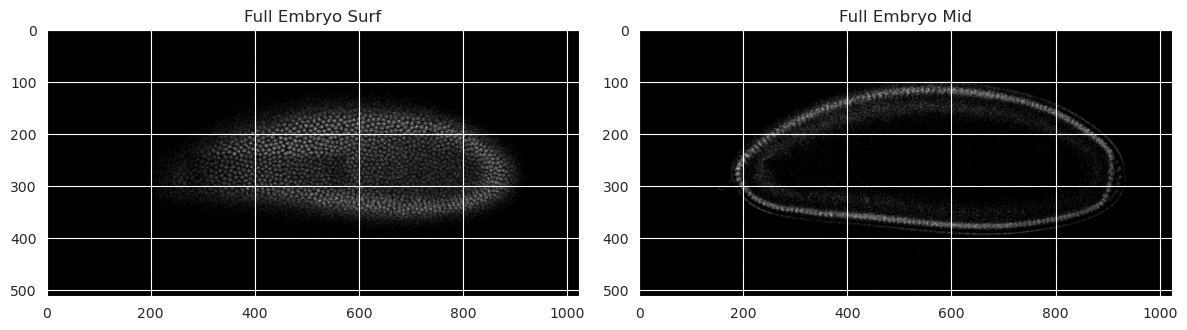

In [10]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(FullEmbryo_dataset.channels_full_dataset_surf[0][0, :, :], cmap='gray')
plt.title('Full Embryo Surf')

plt.subplot(1, 2, 2)
plt.imshow(FullEmbryo_dataset.channels_full_dataset_mid[0][0, :, :], cmap='gray')
plt.title('Full Embryo Mid')

plt.tight_layout()
plt.show()

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
from skimage import color, filters, morphology, util, measure, transform#, exposure, segmentation, io
from scipy.spatial import ConvexHull
from skimage.draw import line
import feret
import cv2 as cv
from skimage.transform import AffineTransform

def contour_mask(binary_mask):
    """
    Generates a mask by flood filling the largest contour within the input binary_mask.
    """
    contours = measure.find_contours(binary_mask)

    # Identify the desired contour (e.g., the largest)
    largest_contour = max(contours, key=len)

    # Fit a convex hull to the contour
    hull = ConvexHull(largest_contour)

    # Initialize the FullEmbryo mask
    mask = np.zeros(binary_mask.shape)

    # Extract points from the contour
    pts0 = [(largest_contour[simplex, 1][0], largest_contour[simplex, 0][0]) for simplex in hull.simplices]
    pts1 = [(largest_contour[simplex, 1][1], largest_contour[simplex, 0][1]) for simplex in hull.simplices]
    pts = pts0 + pts1
    pts = np.array(pts)

    # Calculate reference point for determining polar angle
    reference_point = np.mean(pts, axis=0)

    # Function to calculate the polar angle relative to a reference point
    def polar_angle(point):
        x, y = point[0] - reference_point[0], point[1] - reference_point[1]
        return np.arctan2(y, x)

    # Sort points based on polar angle
    sorted_pts = sorted(pts, key=polar_angle)

    # Draw contour connecting sorted points
    for i in range(len(sorted_pts)):
        if i == len(sorted_pts) - 1:
            x1, y1 = np.round(sorted_pts[i])
            x2, y2 = np.round(sorted_pts[0])
        else:
            x1, y1 = np.round(sorted_pts[i])
            x2, y2 = np.round(sorted_pts[i + 1])

        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x2)
        y2 = int(y2)

        rr, cc = line(y1, x1, y2, x2)
        mask[rr, cc] = 1

    # Save contour mask
    contour_mask = mask

    # Flood fill to generate the FullEmbryo mask
    mask = morphology.flood_fill(mask, (0, 0), 1, connectivity=1)
    mask = util.invert(mask)

    return mask, contour_mask

def gen_full_embryo_mask(tif_array, sigma=10, radius=5):
    """
    Creates a FullEmbryo mask by detecting the embryo edge through a Gaussian blur, thresholding, and a closing operation.
    """
    # Convert the image to grayscale if it's not already
    # if tif_array.shape[-1] == 3:
    #     grayscale_image = color.rgb2gray(tif_array)
    # else:
    #     grayscale_image = tif_array

    # Gaussian blur the image with given sigma
    tif_array = filters.gaussian(tif_array, sigma)

    # Otsu thresholding
    threshold_value = filters.threshold_otsu(tif_array)
    tif_array = tif_array > 1 * threshold_value

    # Closing with disk of given radius
    tif_array = morphology.closing(tif_array, morphology.disk(radius))

    mask, contour = contour_mask(tif_array)
    return mask, contour

In [85]:
image = FullEmbryo_dataset.channels_full_dataset_mid[nuclear_channel][1, :, :]

# Threshold the image
otsu_threshold = filters.threshold_otsu(image)
print(otsu_threshold)
binary_image =image < otsu_threshold
final_image = np.where(binary_image, image, 0)


mask, _ = gen_full_embryo_mask(tif_array=image, sigma=10, radius=5)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(final_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()


21


Exception ignored in: <function Variable.__del__ at 0x7a7c405da710>
Traceback (most recent call last):
  File "/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/tkinter/__init__.py", line 388, in __del__
    if self._tk.getboolean(self._tk.call("info", "exists", self._name)):
RuntimeError: main thread is not in main loop
Exception ignored in: <function Variable.__del__ at 0x7a7c405da710>
Traceback (most recent call last):
  File "/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/tkinter/__init__.py", line 388, in __del__
    if self._tk.getboolean(self._tk.call("info", "exists", self._name)):
RuntimeError: main thread is not in main loop


In [8]:
fullEmbryo = fullEmbryo_pipeline.FullEmbryo(FullEmbryo_dataset, dataset, his_channel=nuclear_channel)

In [9]:
fullEmbryo.find_ap_axis(make_plots=True, remove_small_objects=False, ap_method='minf90', sigma=10, radius=5)

Manual mode activated. Click to select Anterior point, then Posterior point.
AP axis defined. Now click where the perpendicular line intersects the embryo boundaries.
Manual AP and AP90 axes defined.
Anterior Point: (230, 180)
Posterior Point: (307, 848)
AP Angle: 6.58 degrees
AP distance: 672.42 pixels
AP90 distance: 262.72 pixels
Manual mode activated. Click to select Anterior point, then Posterior point.


In [58]:
fullEmbryo.swap_ap_points(make_plots=True)

In [13]:
compiled_dataframe = fullEmbryo.xy_to_ap(compiled_dataframe)
compiled_dataframe.head()

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,ap,ap90
0,1,"[1, 28, 30, 47, 60, 173, 297, 397]","[5.476821700000204, 60.61996270000003, 64.6659...","[79.83865979381444, 14.827050761421317, 66.909...","[42.23450972136382, 37.41725385130317, 36.9488...","[633.1727114630409, 636.236257115834, 635.5783...","[20.154852055209616, 7.134102510161827, 6.5832...","[0.3595289307138823, 0.3600946091947997, 0.359...","[-0.13009053660026818, -0.14043108183238023, -..."
1,2,"[98, 116, 124, 129, 130, 133, 138, 140, 142]","[202.0560957000004, 238.29612669999992, 254.30...","[159.99478125, 116.55248341232227, 56.41650753...","[38.90651211145393, 35.0069039048922, 35.20260...","[790.5368067262802, 791.6889590457631, 791.071...","[8.384042653369914, 7.856076843743435, 10.0152...","[0.40880757374157284, 0.40915477449007365, 0.4...","[-0.1511474836347556, -0.1516446283289524, -0...."
2,4,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...","[70.3869227, 72.40998170000036, 74.25893670000...","[111.41830456852792, 122.82248223350256, 61.19...","[37.36472861538855, 36.3456776282712, 38.00715...","[420.10539550590374, 418.6837299945234, 415.91...","[21.88222256462612, 21.208974904174468, 20.847...","[0.2923694711568811, 0.29190028342212065, 0.29...","[-0.11261171760984895, -0.11302670834039154, -..."
3,6,"[110, 114, 115, 235, 236, 239, 241, 242, 243, ...","[225.9841436999999, 234.07614670000038, 235.92...","[129.051625, 107.33429281767955, 121.958546391...","[32.43571296402123, 33.453938843932725, 38.820...","[922.2878618579562, 921.236388638722, 921.5367...","[41.14136895639339, 41.47561893961533, 42.4183...","[0.45137691027843074, 0.45105550723517174, 0.4...","[-0.1356955768828694, -0.13535644674379607, -0..."
4,7,"[0, 53, 148, 151, 153, 154, 155, 156, 157, 158...","[2.9318267000000926, 110.1509486999996, 303.55...","[108.62177272727271, 23.86940425531914, 104.37...","[43.07320229694602, 39.02498667341372, 36.3910...","[752.2333614611401, 730.6244981370569, 737.878...","[34.8650457319553, 40.71430423146252, 22.49595...","[0.39753963108379115, 0.39090307671642427, 0.3...","[-0.12768814071190454, -0.1215104722202514, -0..."


In [121]:
# Save compiled_dataframe as pickle
compiled_dataframe.to_pickle(test_dataset_name + '/compiled_dataframe.pkl')

## RateExtraction Analysis


### Fit and Average

In [15]:
from transcription_pipeline.RateExtraction import FitAndAverage

In [16]:
# Specify here at what frame NC14 starts
nc14_start_frame = 0

# Any trace with frame number smaller than min_frames will be filtered out
min_frames = 40

# Number of bins you want to split the full embryo into
num_bins = 42

In [17]:
faadata = FitAndAverage(compiled_dataframe, nc14_start_frame, min_frames, num_bins, test_dataset_name)

Load previous particle trace fit checking results from "particle_fits_checked.pkl"


In [18]:
faadata.check_particle_fits()

/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/RateExtraction.py:556: UserWarning: No particle has been left unchecked
  warn('No particle has been left unchecked')


In [19]:
faadata.save_checked_particle_fits()

Checked particle fits updated


In [124]:
faadata.average_particle_fits(plot_results=True, show_slopes=True);

In [25]:
faax, faay, faay_err, _, _ = faadata.average_particle_fits();

Exception ignored in: <function Image.__del__ at 0x76ccb5a25f30>
Traceback (most recent call last):
  File "/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/tkinter/__init__.py", line 4056, in __del__
    self.tk.call('image', 'delete', self.name)
RuntimeError: main thread is not in main loop
Exception ignored in: <function Variable.__del__ at 0x76ccb59c27a0>
Traceback (most recent call last):
  File "/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/tkinter/__init__.py", line 388, in __del__
    if self._tk.getboolean(self._tk.call("info", "exists", self._name)):
RuntimeError: main thread is not in main loop


### Average and Fit (using approved particle fits)

In [26]:
import pandas as pd

faadatapoints = pd.read_pickle(faadata.checked_particle_fits_file_path)

In [27]:
from transcription_pipeline.RateExtraction import AverageAndFit
time_bin_width = dataset.export_frame_metadata[0]['t_s'][1, 0]
aafdata_sp = AverageAndFit(faadatapoints, nc14_start_frame-3, time_bin_width, num_bins, test_dataset_name)

No previous bin fit checking results detected. Do bin fitting for the dataframe.


/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/RateExtraction.py:1082: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.bin_average_fit_dataframe['bin_particle_number'][bin] = bin_particle_num[bin]
/mnt/Data1/Nick/transcript

In [28]:
aafdata_sp.check_bin_fits()

Moved to bin 8 out of 42, the first unchecked bin


Exception ignored in: <function Variable.__del__ at 0x76ccb59c27a0>
Traceback (most recent call last):
  File "/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/tkinter/__init__.py", line 388, in __del__
    if self._tk.getboolean(self._tk.call("info", "exists", self._name)):
RuntimeError: main thread is not in main loop
Exception ignored in: <function Image.__del__ at 0x76ccb5a25f30>
Traceback (most recent call last):
  File "/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/tkinter/__init__.py", line 4056, in __del__
    self.tk.call('image', 'delete', self.name)
RuntimeError: main thread is not in main loop
Exception ignored in: <function Variable.__del__ at 0x76ccb59c27a0>
Traceback (most recent call last):
  File "/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/tkinter/__init__.py", line 388, in __del__
    if self._tk.getboolean(self._tk.call("info", "exists", self._name)):
RuntimeError: main thread is not in main loop

In [44]:
aafdata_sp.bin_average_fit_dataframe;

In [29]:
aafdata_sp.save_checked_bin_fits()

Checked bin fits saved


In [30]:
aafspx, aafspy, aafspy_err = aafdata_sp.plot_bin_fits()

### Average and Fit

In [31]:
from transcription_pipeline.RateExtraction import AverageAndFit

In [32]:
time_bin_width = dataset.export_frame_metadata[0]['t_s'][1, 0]
aafdata = AverageAndFit(compiled_dataframe, nc14_start_frame, time_bin_width, num_bins, test_dataset_name);

Load previous bin fit checking results from "bin_fits_checked.pkl"


In [33]:
aafdata.check_bin_fits()

/mnt/Data1/Nick/transcription_pipeline/transcription_pipeline/RateExtraction.py:1162: UserWarning: No bin has been left unchecked. Move to the first bin with data
  warn('No bin has been left unchecked. Move to the first bin with data')
Exception ignored in: <function Image.__del__ at 0x76ccb5a25f30>
Traceback (most recent call last):
  File "/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/tkinter/__init__.py", line 4056, in __del__
    self.tk.call('image', 'delete', self.name)
RuntimeError: main thread is not in main loop
Exception ignored in: <function Variable.__del__ at 0x76ccb59c27a0>
Traceback (most recent call last):
  File "/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/tkinter/__init__.py", line 388, in __del__
    if self._tk.getboolean(self._tk.call("info", "exists", self._name)):
RuntimeError: main thread is not in main loop
Exception ignored in: <function Variable.__del__ at 0x76ccb59c27a0>
Traceback (most recent call last):
  

In [27]:
aafdata.bin_average_fit_dataframe

,time_bin_centers,time_bin_means,time_bin_stddevs,time_bin_stderrs,denoised_time_bin_means,bin_fit_result,bin_fit_slope,bin_fit_result_modified,bin_fit_slope_modified,bin_particle_number,approval_status
0,None,None,None,None,None,None,NaN,None,NaN,0,-1
1,None,None,None,None,None,None,NaN,None,NaN,0,-1
2,None,None,None,None,None,None,NaN,None,NaN,0,-1
3,None,None,None,None,None,None,NaN,None,NaN,0,-1
4,None,None,None,None,None,None,NaN,None,NaN,0,-1
5,None,None,None,None,None,None,NaN,None,NaN,0,-1
6,None,None,None,None,None,None,NaN,None,NaN,0,-1
7,"[0.037358014999826744, 0.11207404499948023, 0....","[702.2675689467782, 717.5929445032473, 719.826...","[363.6192632905769, 349.74350050249967, 355.32...","[34.513213116188425, 53.335383809751804, 61.85...","[603.9997125745421, 602.9396041200787, 600.590...","[[0.037358014999826744, 0.11207404499948023, 0...",42.143724,None,NaN,74,-1
8,"[0.037358014999826744, 0.11207404499948023, 0....","[317.91777277667546, 376.76447937777857, 351.8...","[255.75453154233963, 242.16155651500642, 247.2...","[26.6642531434963, 39.81111465535611, 41.20992...","[437.47307954506675, 438.9174151207632, 441.96...","[[0.037358014999826744, 0.11207404499948023, 0...",176.000330,None,NaN,53,1
9,"[0.037358014999826744, 0.11207404499948023, 0....","[107.35059695018069, 138.62840770148503, 128.5...","[64.14228526854234, 68.43543835406184, 76.5062...","[10.405252670837713, 13.68708767081237, 16.695...","[211.01239005117213, 212.55931649591554, 215.8...","[[0.037358014999826744, 0.11207404499948023, 0...",267.290661,None,NaN,18,1


In [28]:
aafdata.save_checked_bin_fits()

Checked bin fits saved


In [40]:
aafx, aafy, aafy_err = aafdata.plot_bin_fits()

In [50]:
plt.errorbar(faax, faay, yerr=faay_err, capsize=2, fmt='o', label='faa')
plt.errorbar(aafspx, aafspy, yerr=aafspy_err, capsize=2, fmt='o', label='aaf_sp')
plt.errorbar(aafx, aafy, yerr=aafy_err, capsize=2, fmt='o', label='aaf')


plt.show()